## Analyze the whole-brain voxel-wise GLM results

The numbering of the first-level COPEs:

- 8 basic contrasts:
    1. stim_easy
    2. stim_hard
    3. cue_left
    4. cue_right
    5. cue_neutral
    6. response_left
    7. response_right
    8. error
- `cue`, `stim`, `response`:
    9. cue
    10. stim
    11. response
- The actual constrasts of interest:
    12. Cue payoff - cue neutral (= (cue_left + cue_right) - 2\*cue_neutral)
    13. stim_hard - stim_easy
    14. Response left - response right
    15. Cue left - cue right

The numbering of the third-level COPEs:
1. Intercept positive
2. Dataset
3. Covariate z_shift
4. Covariate v_shift
5. Intercept negative
6. Dataset negative
7. Covariate z_shift negative
8. Covariate v_shift negative

In [1]:
first_level_copes = {'stim_easy': 1,
                     'stim_hard': 2,
                     'cue_left': 3,
                     'cue_right': 4,
                     'cue_neutral': 5,
                     'response_left': 6,
                     'response_right': 7,
                     'error': 8,
                     'cue': 9,
                     'stim': 10,
                     'response': 11,
                     'cue_payoff - cue_neutral': 12,
                     'stim_hard - stim_easy': 13,
                     'response_left - response_right': 14,
                     'cue_left - cue_right': 15}

second_level_copes = {'intercept': 1,
                      'dataset': 2,
                      'z_shift': 3,
                      'v_shift': 4,
                      'v_shift_bias': 5,
                      '-intercept': 6,
                      '-dataset': 7,
                      '-z_shift': 8,
                      '-v_shift': 9,
                      '-v_shift_bias': 10}

In [2]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [3]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

In [4]:
def get_second_level_zmap(first_level_contrast, second_level_contrast, thresholding=None, 
                          base_dir='./derivatives/both/glm_level3'):
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]

    gfeat_dir = os.path.join(base_dir, 'cope{}.gfeat').format(cope1)
    
    if thresholding is None:
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        threshold = 0
    elif thresholding == 'fwer' or thresholding == 'cluster':
        nii_pos = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
        neg_contrast = cope2+5
        nii_neg = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(neg_contrast)
        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nib.load(nii_pos).get_data())
        
    elif thresholding == 'fdr':
        nii = nib.load(os.path.join(gfeat_dir, 'cope1.feat', 'stats', 'zstat{}.nii.gz').format(cope2))
        _, threshold = map_threshold(nii, alpha=0.05, height_control='fdr')

    return nii, threshold

In [5]:
def plot_4x4(z_map, n_cuts=16, **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
    
    if(z_map.get_data().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode='z', colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# plot_4x4(z_map1, threshold=threshold, bg_img=mni09c, title='Test title')

## Contrast-of-interest 1: left_response > right_response

##### FDR thresholding

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


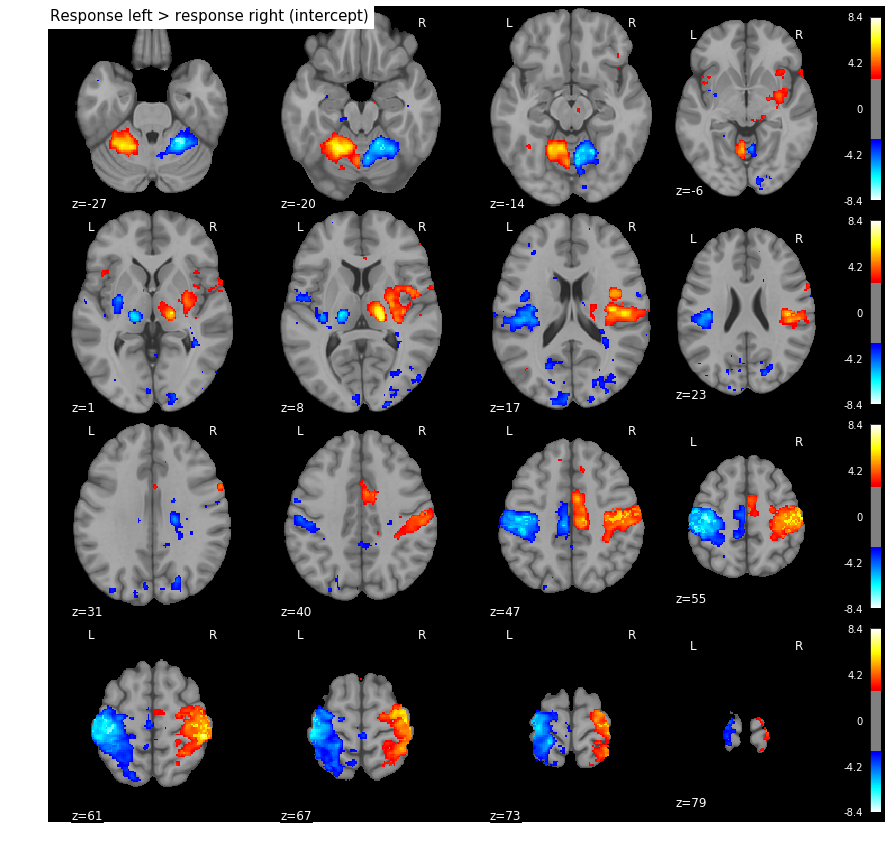

In [6]:
z_map_responselr_intercept, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### Cluster-wise thresholding from FSL

"Significant" voxels were selected by thresholding with a z-value of 3.1 (p=0.001); then clusters were identified using a cluster-wise threshold of p=0.05

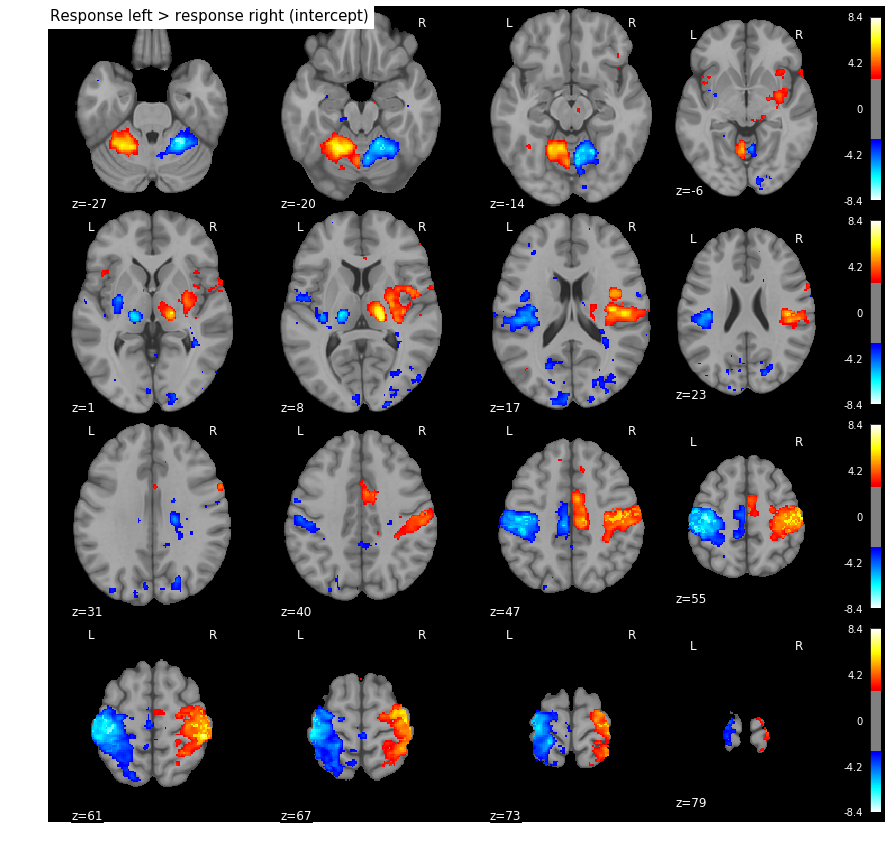

In [7]:
z_map_responselr_intercept_fwer, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_responselr_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Response left > response right (intercept)')

##### any difference between datasets here?

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


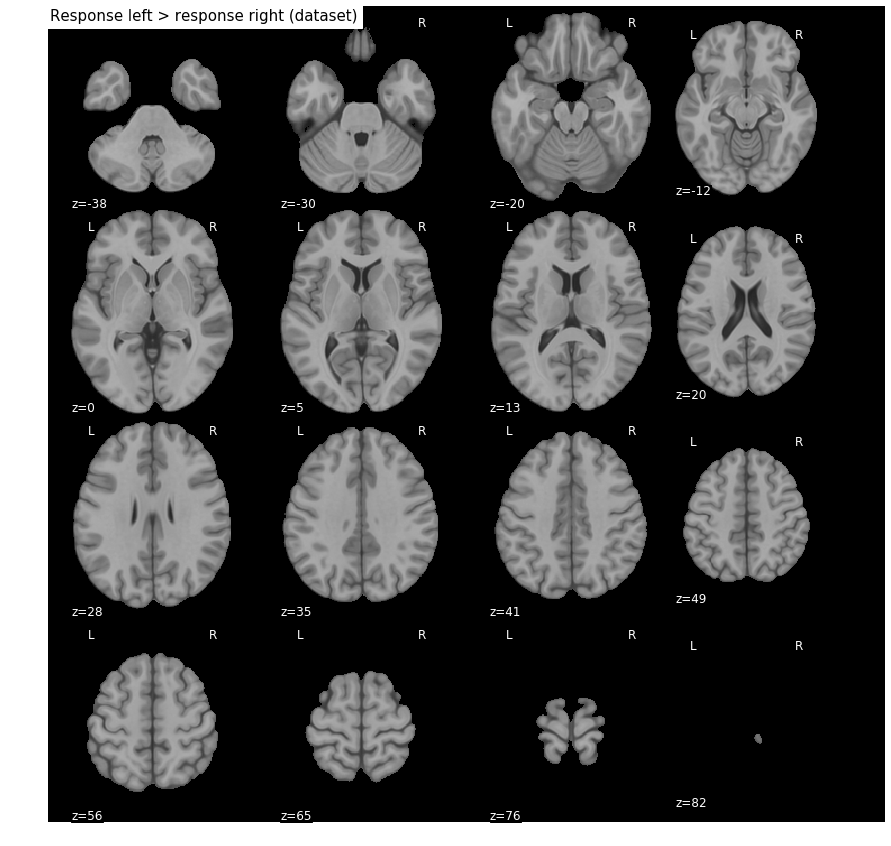

In [8]:
z_map_responselr_dataset, threshold = get_second_level_zmap('response_left - response_right', 'dataset', 'fdr')
f, ax = plot_4x4(z_map_responselr_dataset, threshold=threshold, bg_img=mni09c, title='Response left > response right (dataset)')

##### nothing significant, except there's a posterior-midbrain (thalamus?) increase in values in the Amsterdam data, and a small decrease in right cerebellum

## 2. Effect of error

##### FDR thresholding

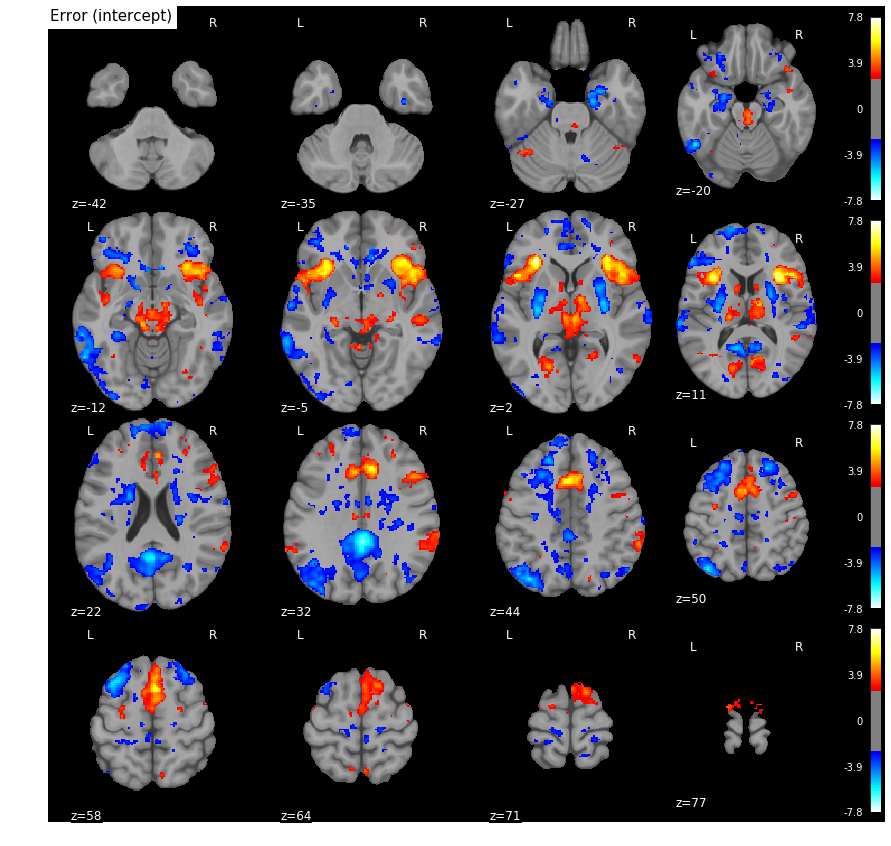

In [9]:
z_map_error_intercept, threshold = get_second_level_zmap('error', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_error_intercept, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

#### FWER cluster thresholding

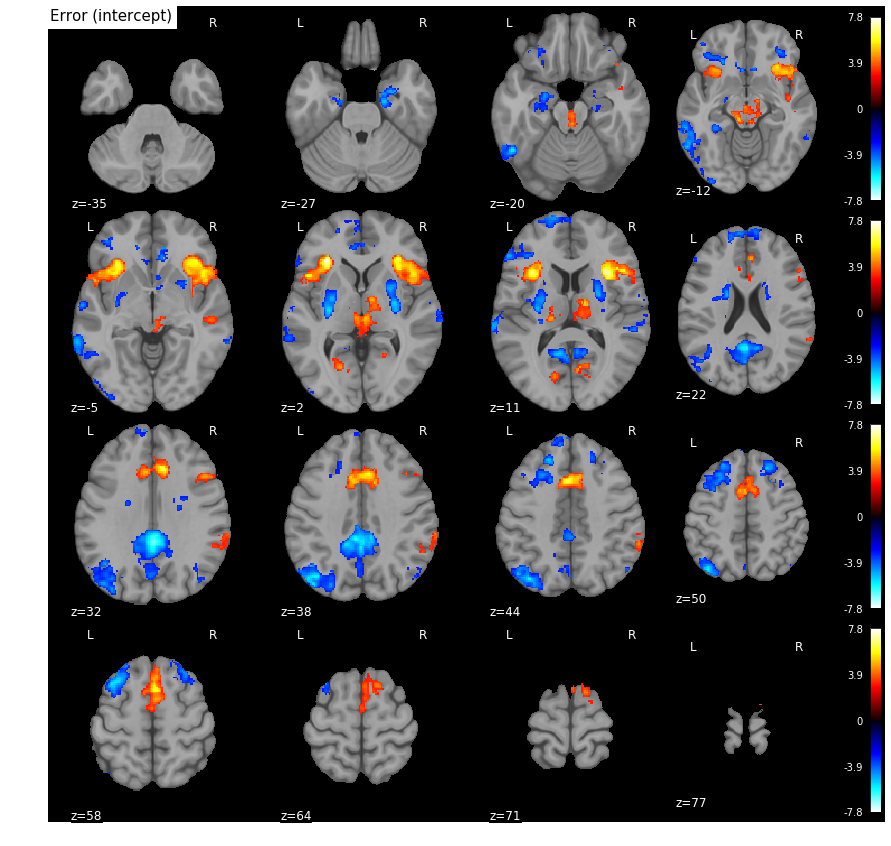

In [10]:
z_map_error_intercept_fwer, threshold = get_second_level_zmap('error', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_error_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Error (intercept)')

It's a messy picture, but we see some positive clusters:
- "cognitive control"-related areas such as insula, and ACC
- prefrontal / premotor areas (preSMA? or even more frontal?) 
- Thalamus
- Some brain stem

And negative:
- A large negative cluster in visual areas that extends quite far superior
- Putamen

## Effect of cue payoff > cue neutral

First, check against second-level intercept

####  FDR

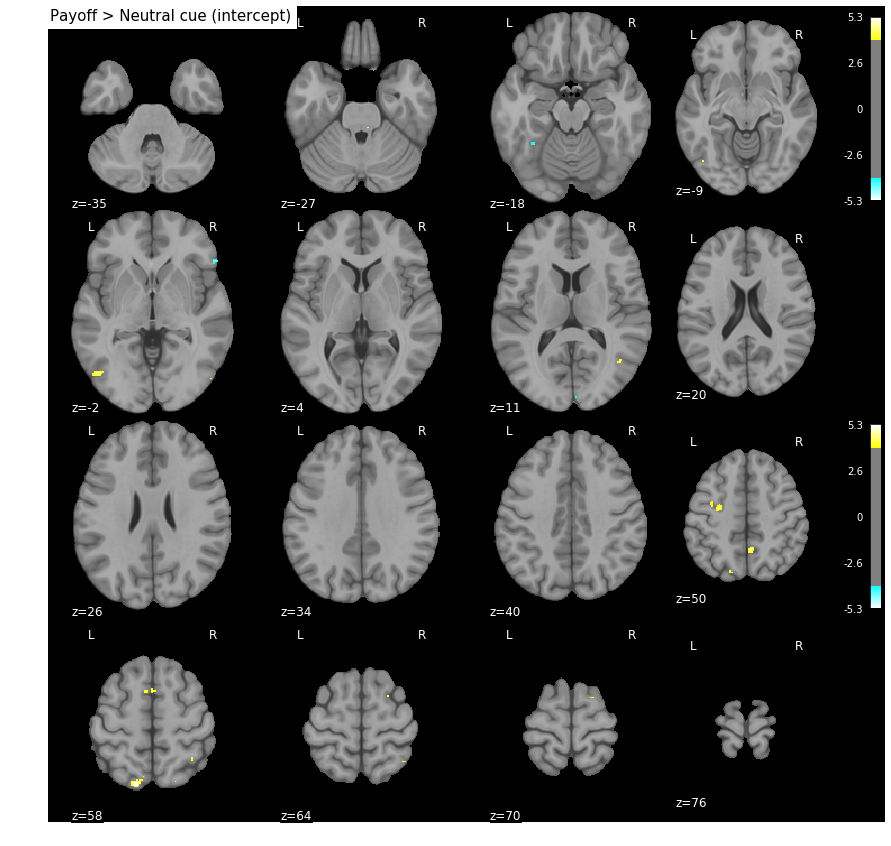

In [11]:
z_map_cue_intercept, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fdr')
f, ax = plot_4x4(z_map_cue_intercept, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

#### FWER cluster

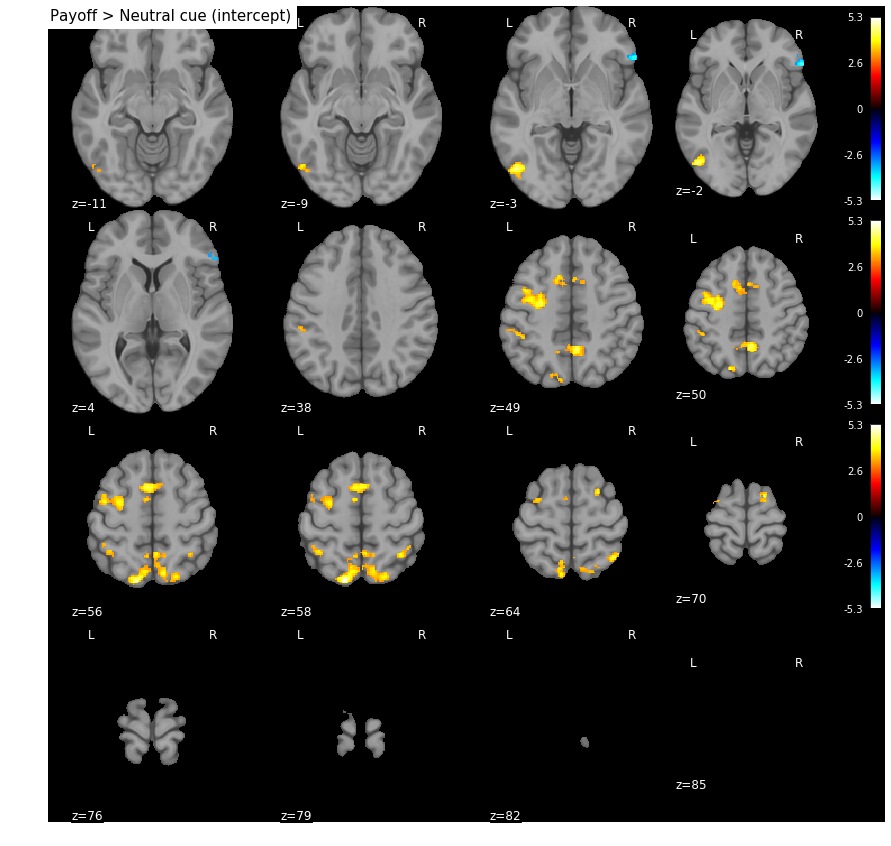

In [12]:
z_map_cue_intercept_fwer, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fwer')
f, ax = plot_4x4(z_map_cue_intercept_fwer, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (intercept)')

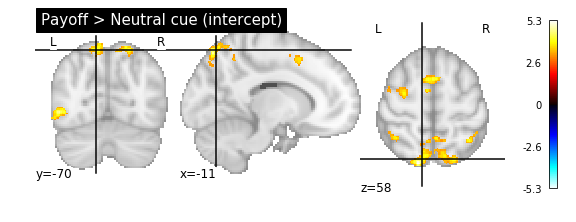

In [13]:
plotting.plot_stat_map(z_map_cue_intercept_fwer, title='Payoff > Neutral cue (intercept)')

##### So there seem to be some effects in parietal and visual cortex, and some frontal (pre-motor?) regions

### Against z-shift, no cluster survives

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa9d3bc50>,
       dtype=object))

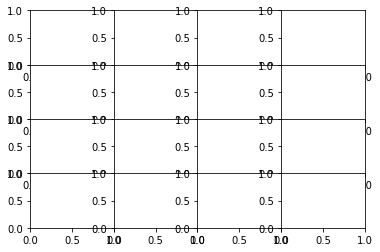

In [14]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'z_shift', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (start point shift)')

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa9cd7240>,
       dtype=object))

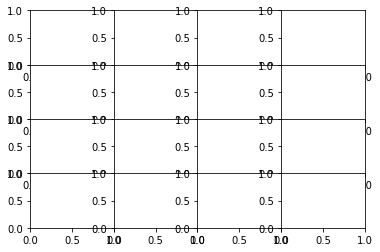

In [15]:
z_map_cue_zshift, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'v_shift_bias', 'fwer')
plot_4x4(z_map_cue_zshift, threshold=threshold, bg_img=mni09c, title='Payoff > Neutral cue (drift bias shift)')

## Hard > Easy

(<Figure size 1080x1080 with 36 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa9d61208>,
       dtype=object))

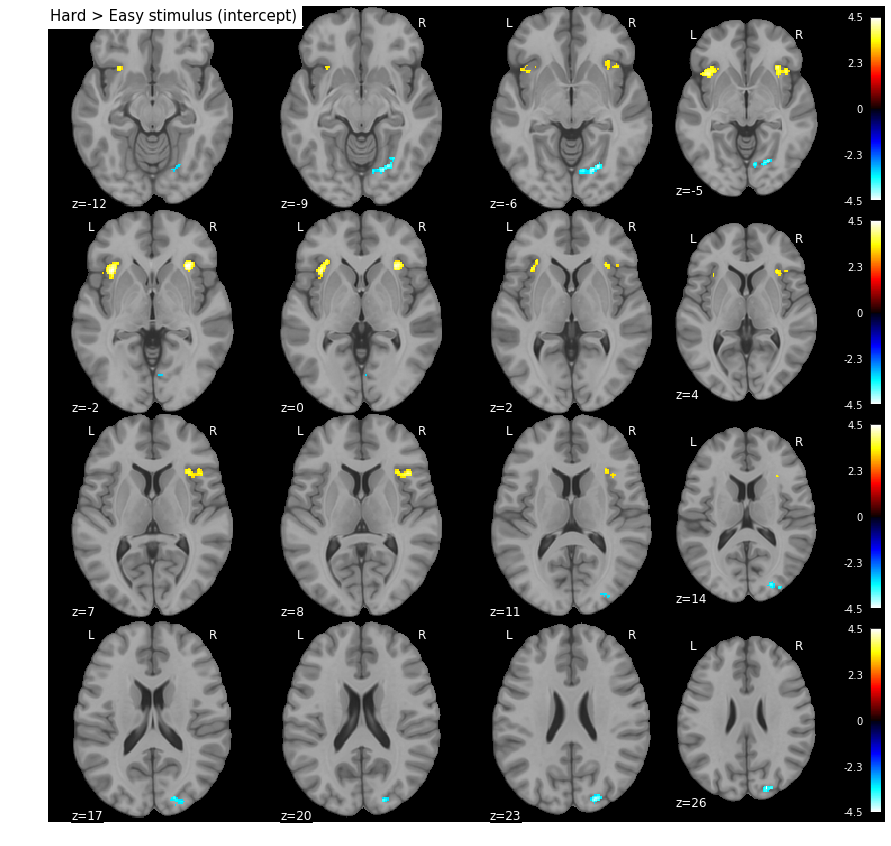

In [16]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
plot_4x4(z_map_diff_intercept, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (intercept)')

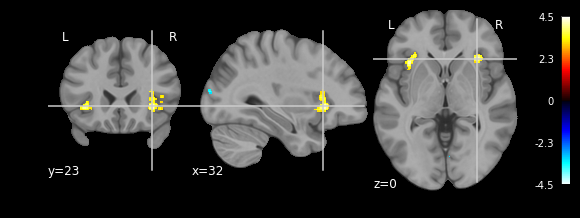

In [22]:
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
plotting.plot_stat_map(z_map_diff_intercept, bg_img=mni09c)

In [25]:
regions_value_img.shape

(129, 153, 129, 2)

In [ ]:
from nilearn.regions import connected_regions
regions_value_img, index = connected_regions(z_map_diff_intercept, extract_type='connected_components', smoothing_fwhm=0, min_region_size=0)

for i in range(regions_value_img.shape[3]):
    plotting.plot_roi(image.index_img(regions_value_img,i), title=i)

(<Figure size 1080x1080 with 35 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa9108d30>,
       dtype=object))

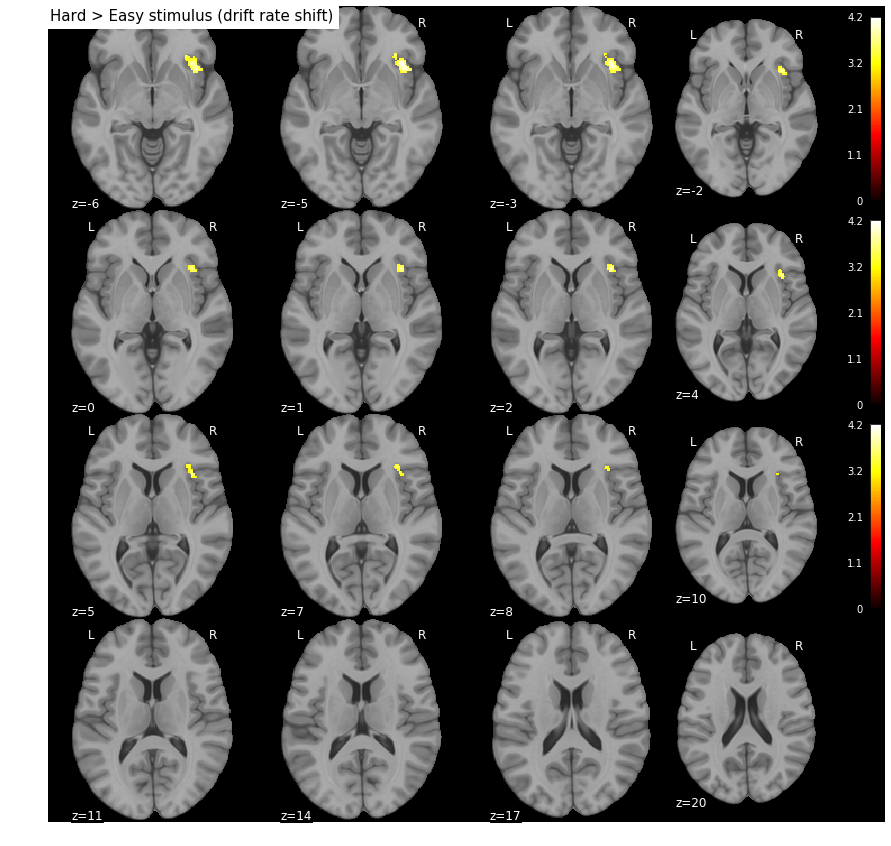

In [17]:
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')
plot_4x4(z_map_diff_vshift, threshold=threshold, bg_img=mni09c, title='Hard > Easy stimulus (drift rate shift)')

## Cue left - Cue right

(<Figure size 1080x1080 with 35 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa86eb4a8>,
       dtype=object))

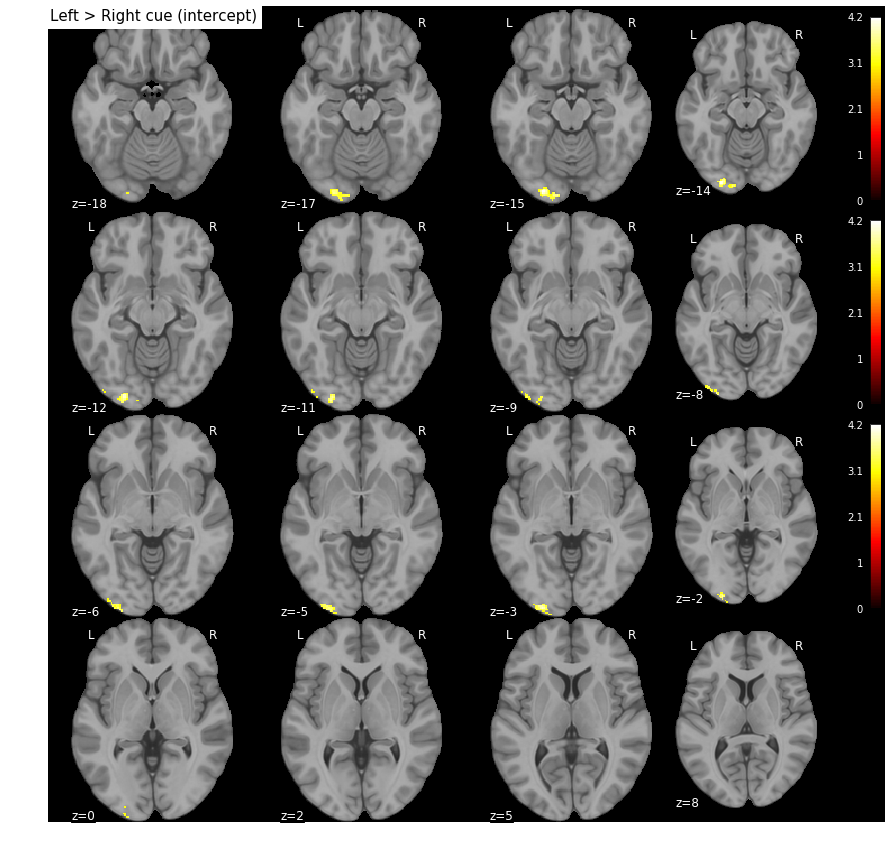

In [18]:
z_map_cuelr_intercept, threshold = get_second_level_zmap('cue_left - cue_right', 'intercept', 'fwer')
plot_4x4(z_map_cuelr_intercept, threshold=threshold, bg_img=mni09c, title='Left > Right cue (intercept)')

No non-zero z-values, nothing to plot!


(<Figure size 432x288 with 16 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa575dd68>,
       dtype=object))

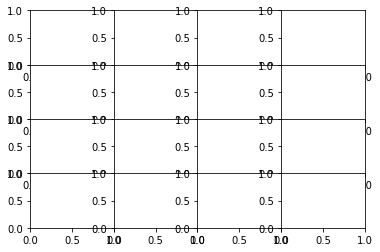

In [19]:
z_map_cuelr_zshift, threshold = get_second_level_zmap('cue_left - cue_right', 'z_shift', 'fwer')  # nothing
plot_4x4(z_map_cuelr_zshift, threshold=threshold, bg_img=mni09c, title='Left > Right cue (start point shift)')

In [20]:
z_map_cuelr_vshift, threshold = get_second_level_zmap('cue_left - cue_right', 'v_shift_drift', 'fwer')  # nothing
plot_4x4(z_map_cuelr_vshift, threshold=threshold, bg_img=mni09c, title='Left > Right cue (start point shift)')

KeyError: 'v_shift_drift'

## Figure for paper

In [45]:
from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%.1f", cmap=plotting.cm.cold_hot, tick_left=True, tick_right=False, is_symmetric=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    
    if nb_ticks > 0:
        ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    else:
        ticks = []
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    if is_symmetric:
        norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
    if tick_left:
        colorbar_ax.yaxis.tick_left()
    if tick_right:
        colorbar_ax.yaxis.tick_right()

    return colorbar_ax

In [7]:
z_map_responselr_intercept_fwer, threshold = get_second_level_zmap('response_left - response_right', 'intercept', 'fwer')
z_map_error_intercept_fwer, threshold = get_second_level_zmap('error', 'intercept', 'fwer')
z_map_cue_intercept_fwer, threshold = get_second_level_zmap('cue_payoff - cue_neutral', 'intercept', 'fwer')
z_map_diff_intercept, threshold = get_second_level_zmap('stim_hard - stim_easy', 'intercept', 'fwer')
z_map_diff_vshift, threshold = get_second_level_zmap('stim_hard - stim_easy', 'v_shift', 'fwer')

Text(0.5, 1.0, 'Difficulty (Hard > Easy)')

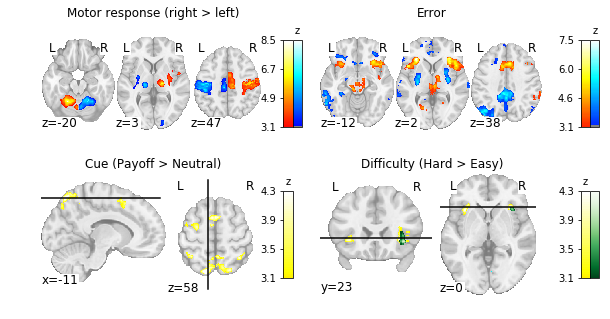

In [76]:
font = {'size'   : 10}
import matplotlib
matplotlib.rc('font', **font)
f = plt.figure(figsize=(10,5))
gridspec = f.add_gridspec(ncols=14, nrows=2, 
                          hspace=.25, wspace=0.0, 
                          width_ratios=np.array([[1]*6 + [1.5]*1] * 2).ravel().tolist())

# left/right
ax0 = f.add_subplot(gridspec[0,0:6])
plotting.plot_stat_map(z_map_responselr_intercept_fwer, display_mode='z', colorbar=False, vmax=8.5,# title='Motor responses (R > L)',
                       cut_coords=[-20, 3, 47], figure=f, axes=ax0, bg_img=mni09c, black_bg=False)  #, **kwargs)
# colorbar
gs00 = gridspec[0,6].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,1]), 
                                truncation_limits=(3.1, 8.5), vmax=8.5, offset=3.1, flip=False, tick_left=True)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs00[1,2]), 
                                truncation_limits=(-3.1,-8.5), 
                                vmax=8.5, offset=3.1, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax0.set_title('Motor response (right > left)')


# error
ax1 = f.add_subplot(gridspec[0,7:13])
plotting.plot_stat_map(z_map_error_intercept_fwer, display_mode='z', colorbar=False, vmax=7.5,
                       cut_coords=[-12, 2, 38], figure=f, axes=ax1, bg_img=mni09c, black_bg=False)
# colorbar
gs01 = gridspec[0,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 2, 1, 1], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,2]), truncation_limits=(3.1,7.5), vmax=7.5, offset=3.1, flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs01[1,3]), truncation_limits=(-3.1,-7.5), vmax=7.5, offset=3.1, flip=True, tick_left=False, nb_ticks=0)
cbar_ax2.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax1.set_title('Error')


# Cue
ax2 = f.add_subplot(gridspec[1,0:6])
plotting.plot_stat_map(z_map_cue_intercept_fwer, display_mode='xz', colorbar=False, vmax=4.3,
                       cut_coords=[-11, 58], figure=f, axes=ax2, bg_img=mni09c, black_bg=False)
gs10 = gridspec[1,6].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 1, 1, 2], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs10[1,1]), truncation_limits=(3.1,4.3), vmax=4.3, offset=3.1, flip=False)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
ax2.set_title('Cue (Payoff > Neutral)')


ax3 = f.add_subplot(gridspec[1,7:13])
disp = plotting.plot_stat_map(z_map_diff_intercept, display_mode='yz', colorbar=False,
                              cut_coords=[23, 0], figure=f, axes=ax3, bg_img=mni09c, vmax=4.3, black_bg=False)
disp.add_overlay(z_map_diff_vshift, cmap='Greens_r', vmax=4.3, vmin=3.1)
gs11 = gridspec[1,-1].subgridspec(3, 4, hspace=0, wspace=0, width_ratios=[2, 2, 1, 1], height_ratios=[0.2, 1, .2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,2]), truncation_limits=(3.1, 4.3), vmax=4.3, offset=3.1, flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=f.add_subplot(gs11[1,3]), 
                                vmin=0, truncation_limits=(0, 4.3), vmax=4.3, offset=0, flip=False, 
                                cmap=plt.get_cmap('Greens_r'), tick_left=False, nb_ticks=0, is_symmetric=False)
cbar_ax1.set_title('z', rotation=0, fontsize=10, ha='center') #, pad=75)
#cbar_ax2.set_ticks([])
ax3.set_title('Difficulty (Hard > Easy)')

#f.tight_layout()
#f.set_size_inches(9,4)  ## approximately A4 width with 1-inch margin

In [77]:
f.savefig('figures/figure2.pdf', bbox_inches='tight')
